In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


matches = pd.read_csv("../data/WWE_History_1000.csv")
features = pd.read_csv("../data/wrestler_features_2023.csv")

Standardize column names

In [8]:
matches.columns = matches.columns.str.strip()
features.columns = features.columns.str.strip()

features.rename(columns={'wrestlers': 'wrestler'}, inplace=True)


Merge winner and looser feature

In [9]:
matches = matches.merge(
    features,
    left_on="Winner",
    right_on="wrestler",
    how="left",
    suffixes=('', '_winner')
)

matches = matches.merge(
    features,
    left_on="Loser",
    right_on="wrestler",
    how="left",
    suffixes=('', '_loser')
)


Remove rows with missing merged data

In [10]:
matches = matches.dropna(subset=[
    'win_rate', 'win_rate_loser',
    'score', 'score_loser',
    'title_wins', 'title_wins_loser',
    'total_matches', 'total_matches_loser'
])


Create proper ML dataset

In [11]:
winner_rows = matches.copy()
winner_rows['target'] = 1

loser_rows = matches.copy()
loser_rows['target'] = 0

# swap winner & loser stats for loser rows
swap_cols = [
    ('win_rate', 'win_rate_loser'),
    ('score', 'score_loser'),
    ('title_wins', 'title_wins_loser'),
    ('total_matches', 'total_matches_loser')
]

for col1, col2 in swap_cols:
    loser_rows[[col1, col2]] = loser_rows[[col2, col1]]

ml_data = pd.concat([winner_rows, loser_rows], ignore_index=True)


Feature Engineering

In [12]:
ml_data['win_rate_diff'] = ml_data['win_rate'] - ml_data['win_rate_loser']
ml_data['score_diff'] = ml_data['score'] - ml_data['score_loser']
ml_data['title_wins_diff'] = ml_data['title_wins'] - ml_data['title_wins_loser']
ml_data['matches_diff'] = ml_data['total_matches'] - ml_data['total_matches_loser']

Prepare ML inputs

In [13]:
X = ml_data[
    ['win_rate_diff', 'score_diff', 'title_wins_diff', 'matches_diff']
]

y = ml_data['target']


Train Logistic Regression model

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

Evaluate model

In [15]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5122699386503068
              precision    recall  f1-score   support

           0       0.55      0.14      0.22       163
           1       0.51      0.88      0.64       163

    accuracy                           0.51       326
   macro avg       0.53      0.51      0.43       326
weighted avg       0.53      0.51      0.43       326



Feature importance

In [16]:
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.coef_[0]
}).sort_values(by='importance', ascending=False)

importance


,feature,importance
1,score_diff,0.265592
0,win_rate_diff,0.077715
3,matches_diff,0.000000
2,title_wins_diff,-0.670912


Visualize feature importance

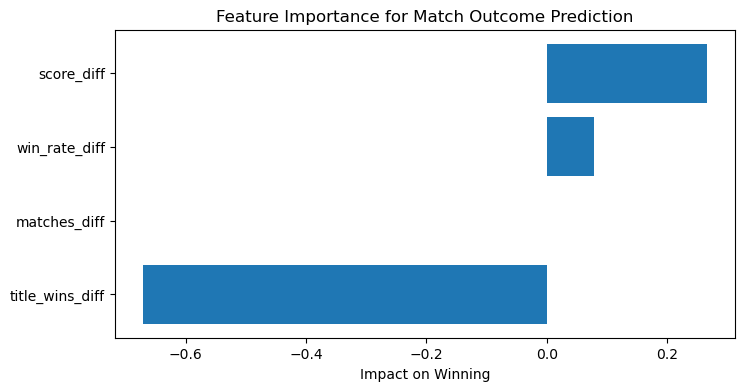

In [17]:
plt.figure(figsize=(8, 4))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel("Impact on Winning")
plt.title("Feature Importance for Match Outcome Prediction")
plt.gca().invert_yaxis()
plt.show()